In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
# import torchvision
# from torchvision import datasets, transforms
# from torch.utils.data import DataLoader

from helper import get_task_datasets, MNISTClassifier

In [2]:
# For reproducibility
torch.manual_seed(327)
np.random.seed(327)

In [3]:
# Randomly select 5 digits between 0 and 9
digits_a = np.random.choice(range(10), size=5, replace=False)
digits_a.sort()

In [4]:
digits_a

array([0, 2, 5, 8, 9])

In [5]:
digits_b = np.array(list(set(range(10)) - set(digits_a)))
digits_b

array([1, 3, 4, 6, 7])

In [6]:
train_loader_a, test_loader_a = get_task_datasets(digits_a)
train_loader_b, test_loader_b = get_task_datasets(digits_b)

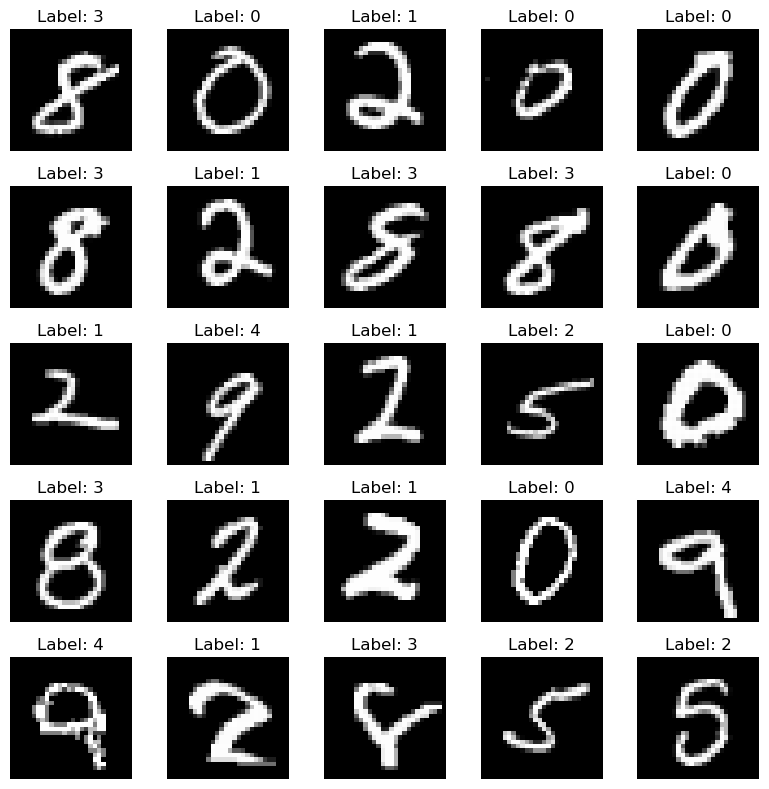

In [7]:
# Sample images for task A
images, labels = next(iter(train_loader_a))

plt.figure(figsize=(8, 8))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f"Label: {labels[i].item()}")
    plt.axis('off')
plt.tight_layout()
plt.show()

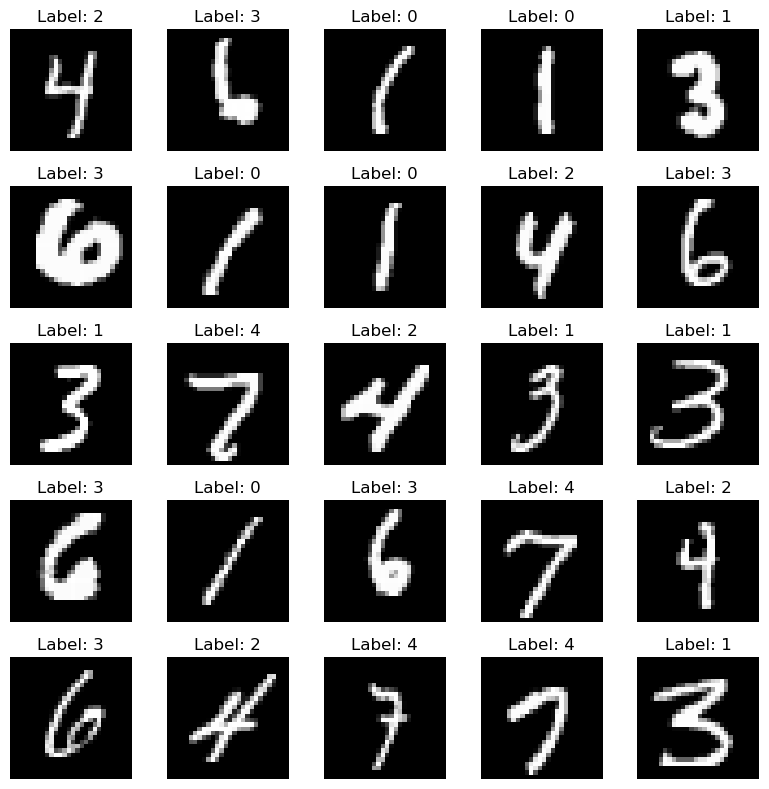

In [8]:
# Sample images for task B
images, labels = next(iter(train_loader_b))

plt.figure(figsize=(8, 8))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f"Label: {labels[i].item()}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Device is {device}")

Device is cuda:0


In [10]:
net = MNISTClassifier(num_classes=5)
net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(net.parameters(), lr=0.001, alpha=0.9)

In [11]:
# Train task A
losses = []

for epoch in range(10):

    running_loss = 0.0
    for i, data in enumerate(train_loader_a, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 0:
            losses.append(running_loss / 100)
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0

[1,     1] loss: 0.016
[1,   101] loss: 0.470
[1,   201] loss: 0.071
[2,     1] loss: 0.000
[2,   101] loss: 0.042
[2,   201] loss: 0.033
[3,     1] loss: 0.001
[3,   101] loss: 0.026
[3,   201] loss: 0.027
[4,     1] loss: 0.001
[4,   101] loss: 0.021
[4,   201] loss: 0.021
[5,     1] loss: 0.000
[5,   101] loss: 0.016
[5,   201] loss: 0.020
[6,     1] loss: 0.000
[6,   101] loss: 0.018
[6,   201] loss: 0.014
[7,     1] loss: 0.000
[7,   101] loss: 0.013
[7,   201] loss: 0.015
[8,     1] loss: 0.000
[8,   101] loss: 0.013
[8,   201] loss: 0.015
[9,     1] loss: 0.000
[9,   101] loss: 0.009
[9,   201] loss: 0.015
[10,     1] loss: 0.000
[10,   101] loss: 0.011
[10,   201] loss: 0.008


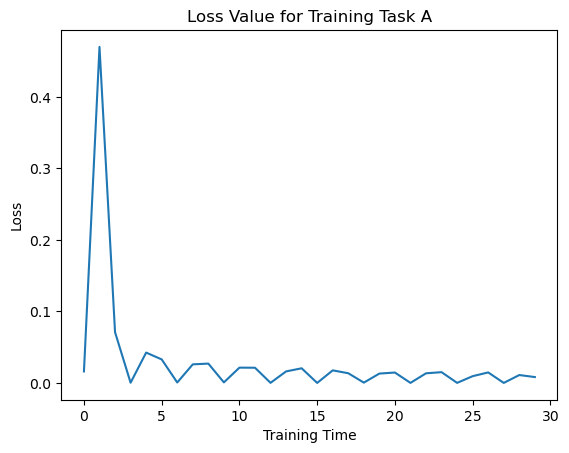

In [12]:
plt.plot(range(len(losses)), losses)
plt.xlabel("Training Time")
plt.ylabel("Loss")
plt.title("Loss Value for Training Task A")
plt.show()

In [13]:
# Evaluate task A accuracy on test data
net.eval()

correct = 0
total = 0

with torch.no_grad():
    for data in test_loader_a:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on test images for task A: {100 * correct / total}%')

Accuracy of the network on test images for task A: 99.40658890935134%


In [14]:
task_a_output_layer = net.fc2

In [15]:
# Train further on task B

# Change output layer for task B
net.fc2 = nn.Linear(in_features=task_a_output_layer.in_features, out_features=digits_b.shape[0])
net.to(device)

# Send new parameters to optimizer
optimizer = optim.RMSprop(net.parameters(), lr=0.001, alpha=0.9)

In [16]:
# Train task B for 3 epochs
losses = []

for epoch in range(3):

    running_loss = 0.0
    for i, data in enumerate(train_loader_b, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 0:
            losses.append(running_loss / 100)
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0

[1,     1] loss: 0.015
[1,   101] loss: 0.050
[1,   201] loss: 0.022
[2,     1] loss: 0.000
[2,   101] loss: 0.010
[2,   201] loss: 0.015
[3,     1] loss: 0.000
[3,   101] loss: 0.008
[3,   201] loss: 0.014


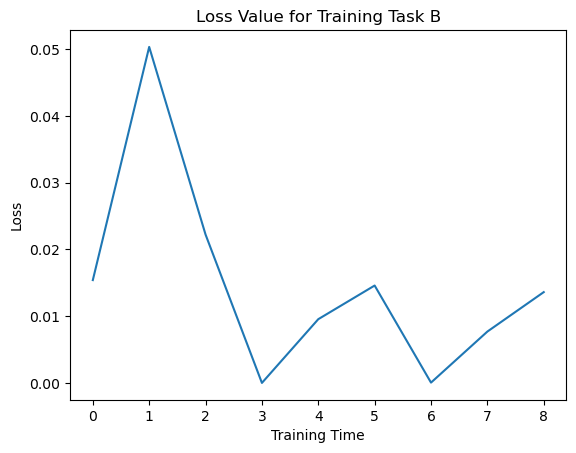

In [17]:
plt.plot(range(len(losses)), losses)
plt.xlabel("Training Time")
plt.ylabel("Loss")
plt.title("Loss Value for Training Task B")
plt.show()

In [18]:
# Evaluate task B accuracy on test data
net.eval()

correct = 0
total = 0

with torch.no_grad():
    for data in test_loader_b:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on test images for task B after training task A: {100 * correct / total}%')

Accuracy of the network on test images for task B after training task A: 99.00254253862703%


In [19]:
# Re-evaluate accuracy of task A
net.fc2 = task_a_output_layer
net.to(device)

net.eval()

correct = 0
total = 0

with torch.no_grad():
    for data in test_loader_a:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on test images for task A after training task B: {100 * correct / total}%')

Accuracy of the network on test images for task A after training task B: 97.46265602619194%
